# Librairies

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import glob
from scipy import ndimage
import time
from skimage.transform import resize

view = 'coronal' #sagittal, axial or coronal
volumes_path = "data/validation/volumes"
labels_path = "data/validation/labels"
img_type = "mhd"

# Functions

In [50]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def create_numpy_volumes(volumes_path, view, img_type):
	print('Create volumes...')
	start_time = time.time()
    
    
	volumes_list = glob.glob(volumes_path+"/*."+img_type) #Create a list of all volumes path
	volumes_list.sort() #Sort alphabetically

    #Create numpy arrays 
	numpy_volumes = np.ndarray((0,128,128,1), dtype=np.uint8) #It will contain all volumes.
	volumes_original_shape = np.ndarray((len(volumes_list),3), dtype=np.uint16) #It will contain all volumes shape

    
	index = 0 #index of the slice position
	index_2 = 0 #index of the volume

	for volume_name in volumes_list :
        
		(mri_volume, origin, spacing) = load_itk(volume_name) #mri_volume is the volume converted in numpy array
        
		volumes_original_shape[index_2] = mri_volume.shape
		index_2 +=1
        
		if(view == 'coronal'):
			mri_volume = np.transpose(mri_volume, (2, 1, 0))
		elif(view == 'axial'):
			mri_volume = np.transpose(mri_volume, (1, 0, 2))
		elif(view == 'sagittal'):
			pass
		else:
			print('\033[93m' + 'Please select a view among : coronal, axial and sagittal' + '\033[0m')

    
		mri_volume = 255 / np.amax(mri_volume) * mri_volume #Normalize the maximum intensity to 255
		mri_volume = mri_volume.astype('uint8')

    
        #increase the size of numpy_volumes corresponding to the volume processed in this loop
		numpy_volumes = np.lib.pad(numpy_volumes, ((0,mri_volume.shape[0]),(0,0),(0,0),(0,0)), 'constant', constant_values=(0))
    
		#Resize every slices and add them into numpy_volumes
		for i in range(0,mri_volume.shape[0]):
        
			mri_slice_res = cv2.resize(mri_volume[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            
			mri_slice_res = mri_slice_res[..., np.newaxis] #add an axis to mri_slice_res to fit numpy_volumes
            
			numpy_volumes[i + index] = mri_slice_res

		index = index + mri_volume.shape[0]
        
	print('Shape of the volumes numpy array : ',numpy_volumes.shape, 'for ', index_2, ' volumes')
	print('Type of the array is : ',numpy_volumes.dtype)
	print("Time to process --- %s seconds ---" % (time.time() - start_time))
	print()
    
	return numpy_volumes, volumes_original_shape









def create_numpy_labels(labels_path, view, img_type):
    print('Create labels...')
    start_time = time.time()
    labels_list = glob.glob(labels_path+"/*."+img_type) #Create a list of all labels path
    labels_list.sort() #Sort alphabetically

    #Create a numpy arrays 
    numpy_labels = np.ndarray((0,128,128,1), dtype=np.uint8) #It will contain all labels.
    labels_original_shape = np.ndarray((len(labels_list),3), dtype=np.uint16) #It will contain all labels shape
    
    index = 0 #index of the slice position
    index_2 = 0 #index of volume position
    
    for label_name in labels_list :
    
        #mri_label is the 3D label converted in numpy array
        (mri_label, origin, spacing) = load_itk(label_name)
        labels_original_shape[index_2] = mri_label.shape
        index_2 +=1
        
        #select the view
        if(view == 'coronal'):
            mri_label = np.transpose(mri_label, (2, 1, 0))
        elif(view == 'axial'):
            mri_label = np.transpose(mri_label, (1, 0, 2))
        elif(view == 'sagittal'):
            pass
        else:
            print('\033[93m' + 'Please select a view among : coronal, axial and sagittal' + '\033[0m')
            
        #increase the size of numpy_labels corresponding to the 3d label processed in this loop
        numpy_labels = np.lib.pad(numpy_labels, ((0,mri_label.shape[0]),(0,0),(0,0),(0,0)), 'constant', constant_values=(0))
    
    
        #We resize every slices and put them into numpy_volumes
        for i in range(0,mri_label.shape[0]):
        
            mri_slice_res = cv2.resize(mri_label[i], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        
            mask1 = mri_slice_res == 2 #Femur cartilage
            mri_slice_res[mask1] = 0

            mask2 = mri_slice_res == 4 #Tibia cartilage
            mri_slice_res[mask2] = 0

            mask3 = mri_slice_res == 1 #Femur
            mri_slice_res[mask3] = 0

            mask4 = mri_slice_res == 3 #Tibia
            mri_slice_res[mask4] = 255
        
            #Opening to erase the defaults due to resizing
            mri_slice_res = ndimage.binary_opening(mri_slice_res, structure=np.ones((3,3))).astype(int)
            #mri_slice_res = ndimage.remove_small_objects(mri_slice_res, 8)
        
            mask5 = mri_slice_res == 1
            mri_slice_res[mask5] = 255
        
            mri_slice_res = mri_slice_res[..., np.newaxis] #add an axis to mri_slice_res to fit numpy_labels

            numpy_labels[i + index] = mri_slice_res
        
    
        index = index + mri_label.shape[0]

    
    print('Shape of the labels numpy array : ',numpy_labels.shape, 'for ', index_2, ' volumes')
    print('Type of the array is : ',numpy_labels.dtype)
    print("Time to process --- %s seconds ---" % (time.time() - start_time))
    print()
    
    return numpy_labels, labels_original_shape




# Convert volumes and labels into Numpy array

In [51]:
numpy_volumes, volumes_original_shape = create_numpy_volumes(volumes_path, view, img_type)
numpy_labels, labels_original_shape = create_numpy_labels(labels_path, view, img_type)

Create volumes...
Shape of the volumes numpy array :  (4292, 128, 128, 1) for  15  volumes
Type of the array is :  uint8
Time to process --- 2.4315226078033447 seconds ---

Create labels...
Shape of the labels numpy array :  (4292, 128, 128, 1) for  15  volumes
Type of the array is :  uint8
Time to process --- 2.931133985519409 seconds ---



# Shuffle labels and volumes in unison

In [75]:
#Shuffling is not mandatory. Depending of the dataset, shuffling could result to a skewed test set. Do not shuffle for SKI10 dataset
start_time = time.time()
[numpy_volumes, numpy_labels] = unison_shuffled_copies(numpy_volumes, numpy_labels)
print("Volumes and labels have been shuffled in unison")
print("Time to process --- %s seconds ---" % (time.time() - start_time))

Volumes and labels have been shuffled in unison
Time to process --- 0.12169623374938965 seconds ---


#  Separate Train, Validation and Test dataset then save them as numpy array

In [52]:
start_time = time.time()
ratio = 1 #ratio of training + validation data / test data
index = int(ratio*numpy_volumes.shape[0])

ratio_v = 0 #ratio of training / validation data
index_v = int(ratio_v*index)


train_volumes = numpy_volumes[:index_v, :, :, :]
train_labels = numpy_labels[:index_v, :, :, :]

validation_volumes = numpy_volumes[index_v:index, :, :, :]
validation_labels = numpy_labels[index_v:index, :, :, :]

test_volumes = numpy_volumes[index:, :, :, :]
test_labels = numpy_labels[index:, :, :, :]


print('Shape of the train volumes array : ',train_volumes.shape)
np.save('data/npydata/train_volumes.npy', train_volumes)
print('Shape of the train labels array : ',train_labels.shape)
np.save('data/npydata/train_labels.npy', train_labels)


print('Shape of the validation volumes array : ',validation_volumes.shape)
np.save('data/npydata/validation_volumes.npy', validation_volumes)
print('Shape of the validation labels array : ',validation_labels.shape)
np.save('data/npydata/validation_labels.npy', validation_labels)


print('Shape of the test volumes array : ',test_volumes.shape)
np.save('data/npydata/test_volumes.npy', test_volumes)
print('Shape of the test labels array : ',test_labels.shape)
np.save('data/npydata/test_labels.npy', test_labels)

print("Time to process --- %s seconds ---" % (time.time() - start_time))

Shape of the train volumes array :  (0, 128, 128, 1)
Shape of the train labels array :  (0, 128, 128, 1)
Shape of the validation volumes array :  (4292, 128, 128, 1)
Shape of the validation labels array :  (4292, 128, 128, 1)
Shape of the test volumes array :  (0, 128, 128, 1)
Shape of the test labels array :  (0, 128, 128, 1)
Time to process --- 0.3748972415924072 seconds ---


# Visualize data

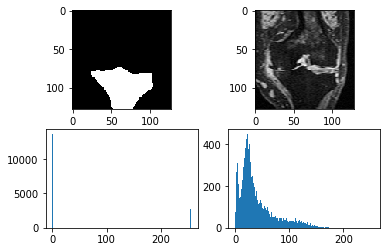

In [30]:
slice = 1250
f = plt.figure()
f.add_subplot(2,2, 1)
#plt.imshow(train_labels[slice][:,:,0], cmap='gray')
plt.imshow(train_labels[slice][:,:,0], cmap='gray')
f.add_subplot(2,2, 2)
#plt.imshow(train_volumes[slice][:,:,0], cmap='gray')
plt.imshow(train_volumes[slice][:,:,0], cmap='gray')
f.add_subplot(2,2, 3)
plt.hist(train_labels[slice][:,:,0].ravel(),256,[0,256])
f.add_subplot(2,2, 4)
plt.hist(train_volumes[slice][:,:,0].ravel(),256,[0,256])
plt.show(block=True)